In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error


In [15]:
# Load dataset
# Specify the path to your CSV file
csv_file_path = 'AEP_hourly.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)
df = df.sort_index()
df.index.freq = pd.infer_freq(df.index)  # Infer the frequency (e.g., 'H' for hourly)


In [16]:
from statsmodels.tsa.stattools import adfuller

# Calculate seasonal difference (hourly data with daily seasonality)
df['AEP_MW_shifted'] = df['AEP_MW'].shift(24)  # Shift by 24 hours for daily seasonality
df['AEP_MW_seasonal_diff'] = df['AEP_MW'] - df['AEP_MW_shifted']

# Drop NaN values resulting from the shift
df.dropna(inplace=True)

# Perform Augmented Dickey-Fuller (ADF) test on the seasonal difference
result = adfuller(df['AEP_MW_seasonal_diff'])
print("ADF Statistic for Seasonal Differencing:", result[0])
print("p-value for Seasonal Differencing:", result[1])


ADF Statistic for Seasonal Differencing: -47.951808928769324
p-value for Seasonal Differencing: 0.0


In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define SARIMA model parameters (example)
order = (1, 1, 1)  # Non-seasonal parameters (p, d, q)
seasonal_order = (1, 1, 1, 24)  # Seasonal parameters (P, D, Q, seasonal_period)
# Use a subset of the data (e.g., first 1000 rows) for analysis
subset_data = df['AEP_MW'].iloc[:1000]

# Fit SARIMA model with subset data
sarima_model = SARIMAX(subset_data, order=order, seasonal_order=seasonal_order)
sarima_result = sarima_model.fit()


C:\Users\mobiz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\mobiz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


C:\Users\mobiz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\mobiz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


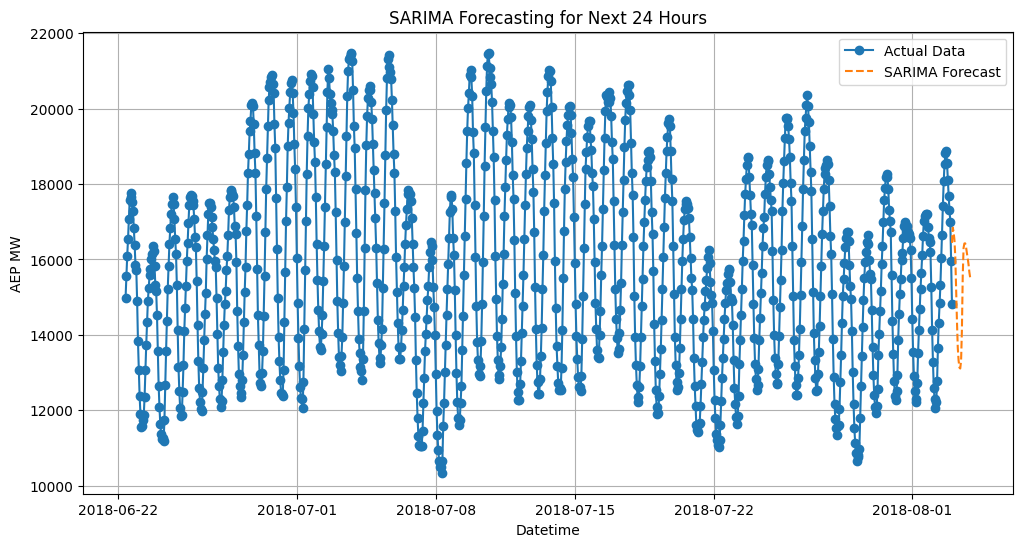

In [18]:
# Forecast future values
data_last_1000 = df.tail(1000)

forecast_steps = 24
forecast_sarima = sarima_result.forecast(steps=forecast_steps)

# Generate datetime index for forecast starting from the last timestamp in actual data
forecast_index = pd.date_range(start=data_last_1000.index[-1], periods=forecast_steps, freq='H')

# Plot actual data and SARIMA forecasted values
plt.figure(figsize=(12, 6))
plt.plot(data_last_1000.index, data_last_1000['AEP_MW'], label='Actual Data', marker='o')
plt.plot(forecast_index, forecast_sarima, label='SARIMA Forecast', linestyle='--')

plt.xlabel('Datetime')
plt.ylabel('AEP MW')
plt.title('SARIMA Forecasting for Next 24 Hours')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
actual_values = data_last_1000['AEP_MW']
print(actual_values)

Datetime
2018-06-22 09:00:00    14978.0
2018-06-22 10:00:00    15557.0
2018-06-22 11:00:00    16087.0
2018-06-22 12:00:00    16544.0
2018-06-22 13:00:00    17081.0
                        ...   
2018-08-02 20:00:00    17673.0
2018-08-02 21:00:00    17303.0
2018-08-02 22:00:00    17001.0
2018-08-02 23:00:00    15964.0
2018-08-03 00:00:00    14809.0
Name: AEP_MW, Length: 1000, dtype: float64
